# DenoiseNet

DenoiseNet is a neural network that takes in a raw, uncleaned pointcloud, and outputs a clean pointcloud with a lot less noisy points. This notebook will walk you through the intuition of designing a model to perform deeplearning on this specific task of per-point noise classification

## Where to Start

When looking to create a model for a certain task, we first need to understand the data that will power the model. Since the task of our model is to classify each point in a point cloud, we will need a large dataset of point clouds. A point cloud will be defined as a collection of points of size `N x 3`, where N is equal to the number of points and each point has an x, y, and z value

### Inputs and Outputs

To understand how our dataset will look, we need to decide what our model should accept as input, and what our model should output as a result. For an input, our model will take in a point cloud. This `input` can be expected to be an unclean point cloud, where many of the points that make up the object are actually outliers that should not be part of the point cloud. The `output` should be a classification for every single point of the input. This will be of shape `N x 1` where each point has either a 0 for a clean point, or 1 for a noisy point. This output will allow users to effectively denoise their input point clouds 



## Environment Setup

DenoiseNet is tested with Python 3.11. It is recommended to use this version of Python, otherwise it is more likely for things to break. The operating system used to test the project is Windows 11.

To set up our environment, we first must create a virtual environment. To do this, open a terminal and enter the following command:

`python -m venv venv`

Please note that if `python -V` says we are not using Python 3.11, you might want to fix that. To make a virtual environment in 3.11, make sure to instead do the following:

- download python 3.11 if you don't already have it from `https://www.python.org/downloads/release/python-3110/`
- locate the location of the newly downloaded python.exe (version 11)
- run `path\to\python.exe -m venv venv`

Python versions are typically stored in `C:\Users\<username>\AppData\Local\Programs\Python`. So you should head there and check for a folder called Python311.
Otherwise you can check out this post `https://stackoverflow.com/questions/647515/how-can-i-find-where-python-is-installed-on-windows`


Now you should have a virtual environment. Activate it by doing `.\venv\Scripts\activate`. Verify we are using Python 11 by doing `python -V`

Now we need to make the notebook utilize the virtual environment. This notebook assumes you are using VSCode as an IDE. Hit `ctrl + shift + p` and type in `Python: Select Interpreter`, then select that from the dropdown menu and select the virtual environment you created. Do the same thing again, but for the command Notebook: Select Notebook Kernel (May require you to restart VSCode or run the command `Developer: Reload Window`)

### Install Requirements

Now that the environment is created, all we need to do is run `pip install -r requirements.txt`. This will install the following packages:
- requests
- matplotlib
- pandas
- trimesh
- open3d
- torch
- tqdm
- scipy

If you are having issues installing pytorch, you may want to remove it from the requirements.txt file and pip install it manually. The command can be found from `https://pytorch.org/get-started/locally/`


## Dataset

With an understanding of what our input and output should be, we can now look into creating a dataset. Each entry in our dataset should just match our input, and output. This data can be obtained through the creation of a synthetic dataset sampled from the ModelNet10 dataset. ModelNet10 is a dataset made up of mesh files of 10 different types of objects. Using these mesh files, it is possible to sample points to turn the dataset into a collection of point cloud files. From here, we can create our noisy input point clouds as well as our output classification labels. This will be done by corrupting our point clouds with noise, and recording which points we added as noise for the labels

Before starting this process, `lets download the ModelNet10 dataset`

In [1]:
import os
import requests
import zipfile
import shutil
import stat

def download_modelnet10(url: str, destination: str, cleanup: bool):
    """Download the modelnet10 dataset and delete unneeded files if cleanup is True"""

    if not os.path.isdir("dataset"):
        os.makedirs("dataset")

    if os.path.exists("dataset/ModelNet10"):
        return

    filename = url.split('/')[-1].replace(" ", "_")
    file_path = os.path.join(destination, filename)

    r = requests.get(url, stream=True)
    if r.ok:
        print(f"saving to \"{os.path.abspath(file_path)}\"")
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 8):
                if chunk:
                    f.write(chunk)
                    f.flush()
                    os.fsync(f.fileno())
    else:  # HTTP status code 4XX/5XX
        print("Download failed: status code {}\n{}".format(r.status_code, r.text))

    with zipfile.ZipFile("dataset/ModelNet10.zip", 'r') as zip_ref:
        zip_ref.extractall("dataset")

    if cleanup:
        os.remove("dataset/ModelNet10.zip")
        os.remove("dataset/ModelNet10/README.txt")
        directory_path = "dataset/__MACOSX"
        shutil.rmtree(directory_path, onerror=lambda func, path, exc: os.chmod(path, stat.S_IWRITE)) # avoid WIN10 permission error

In [2]:
URL = "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip"
DESTINATION = "dataset"

download_modelnet10(url=URL, destination=DESTINATION, cleanup=True)

saving to "c:\Users\jwilder\home\DenoiseNet\dataset\ModelNet10.zip"


To understand what we are working with, let's plot some information about ModelNet10

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_modelnet_categories(modelnet_path: str, text: bool=True):
    """graph the amount of examples for each category in the dataset"""
    categories = []
    total_files = []

    for folder in os.listdir(modelnet_path):
        if folder == ".DS_Store": continue
        subfolder = os.path.join(modelnet_path, folder)
        train_files = len(os.listdir(os.path.join(subfolder, "train")))
        test_files = len(os.listdir(os.path.join(subfolder, "test")))
        total = train_files + test_files
        
        categories.append(folder.replace("_", " "))
        total_files.append(total)

    plt.figure(figsize=(12, 6))
    plt.bar(categories, total_files, color='skyblue')
    plt.xlabel('Categories')
    plt.ylabel('Total Files')
    plt.title('Total Files per Category in ModelNet Dataset')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    if text:
        df = pd.DataFrame([total_files], columns=categories)
        df['Total'] = df.sum(axis=1)
        df.index = ['Amount']
        display(df)


        

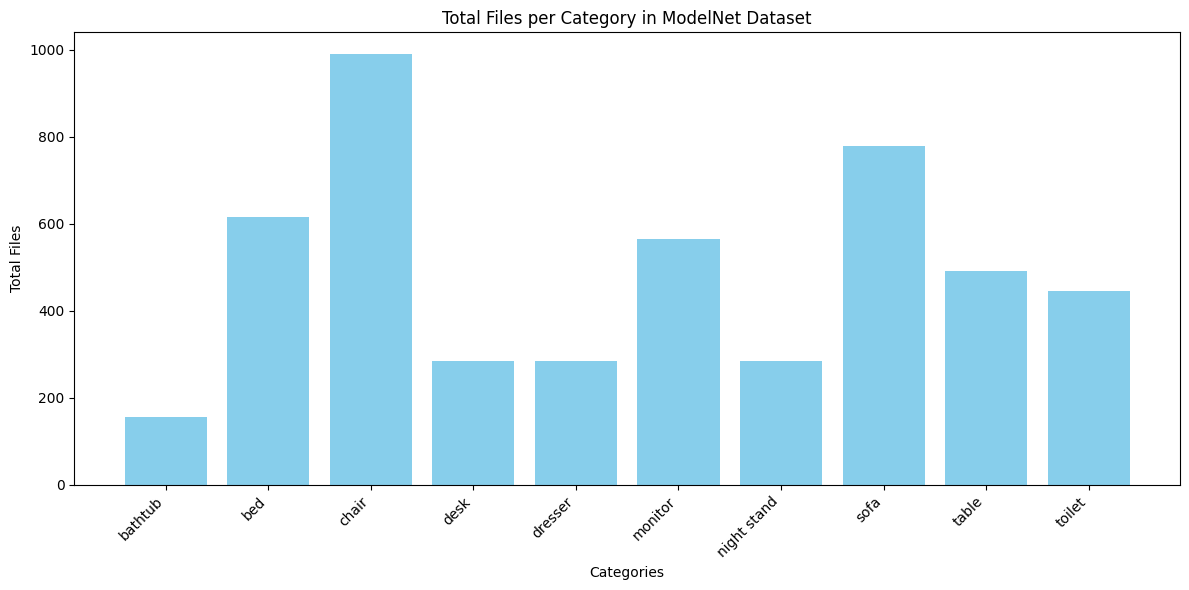

,bathtub,bed,chair,desk,dresser,monitor,night stand,sofa,table,toilet,Total
Amount,156,617,991,286,286,565,286,780,492,446,4905


In [6]:
plot_modelnet_categories("dataset\\ModelNet10")

Let's display an example from the ModelNet dataset

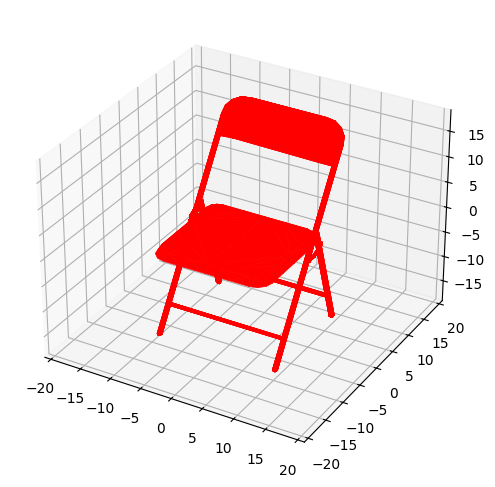

In [7]:
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def display_mesh(mesh_path):
    mesh = trimesh.load(mesh_path)

    vertices = mesh.vertices
    faces = mesh.faces

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    poly3d = [[vertices[vertice] for vertice in face] for face in faces]
    ax.add_collection3d(Poly3DCollection(poly3d, facecolors='red', linewidths=0.5, edgecolors='r'))

    # Set correct scaling
    scale = vertices.flatten()
    ax.auto_scale_xyz(scale, scale, scale)

    plt.show()

mesh_path = "dataset/ModelNet10/chair/train/chair_0001.off"
display_mesh(mesh_path)


### Synthetic Dataset

Now that we have the base ModelNet10 dataset, we can manipulate it to be in the format that we need. As you see above, we currently have mesh files. Mesh files can be thought of as a list of vertices and edges that make up a 3D object. We will need to sample points along the faces of the object to convert the mesh to a point cloud. Let's go ahead and make a class to handle this, as well as all the other helper functions we will need to create the synthetic dataset

In [9]:
import open3d as o3d
import numpy as np
import torch


class DatasetUtils:
    
    @staticmethod
    def mesh_to_pointcloud(file_path: str, num_points: int = 1024) -> torch.Tensor:
        """Convert a mesh file to a point cloud tensor by randomly sampling points"""
        mesh = o3d.io.read_triangle_mesh(file_path)
        pcd = mesh.sample_points_uniformly(number_of_points=num_points)
        points = np.asarray(pcd.points, dtype=np.float32)
        centered_pointcloud = points - np.mean(points, axis=0)
        norm_pointcloud = centered_pointcloud / np.max(np.linalg.norm(centered_pointcloud, axis=1))

        return torch.from_numpy(norm_pointcloud)
    
    @staticmethod
    def add_noise_to_pcd(pcd: torch.tensor, num_noise_points: int, offset_strength: float = .1):
        """Obfuscate a point cloud by adding random noisy points and return binary labels"""
        num_points = pcd.size(0)
        noise_points = []

        for _ in range(num_noise_points):
            random_idx = torch.randint(0, num_points, (1,)).item()
            random_offset = torch.FloatTensor(3).uniform_(-offset_strength, offset_strength)
            noisy_point = pcd[random_idx] + random_offset
            noise_points.append(noisy_point)

        noise_points = torch.stack(noise_points)
        combined_points = torch.vstack((pcd, noise_points))

        clean_labels = torch.ones(num_points, dtype=torch.float32)
        noise_labels = torch.zeros(num_noise_points, dtype=torch.float32)
        combined_labels = torch.cat((clean_labels, noise_labels))

        return combined_points, combined_labels
    
    @staticmethod
    def add_valid_noise_to_pcd(pcd: torch.Tensor, num_noise_points: int, offset_strength: float = 0.5) -> torch.Tensor:
        """Add random noise points to the point cloud, restricted to spots that are not valid clean point locations"""
        min_bound = torch.min(pcd, dim=0)[0].float()
        max_bound = torch.max(pcd, dim=0)[0].float()

        noise_points = torch.empty((num_noise_points, 3))

        for i in range(num_noise_points):
            side = torch.randint(0, 6, (1,)).item()

            # Point must be outside of bounding box
            if side == 0:
                noise_points[i, 0] = min_bound[0] - offset_strength * torch.rand(1).item()
                noise_points[i, 1] = torch.rand(1).item() * (max_bound[1] - min_bound[1]) + min_bound[1]
                noise_points[i, 2] = torch.rand(1).item() * (max_bound[2] - min_bound[2]) + min_bound[2]
            elif side == 1:
                noise_points[i, 0] = max_bound[0] + offset_strength * torch.rand(1).item()
                noise_points[i, 1] = torch.rand(1).item() * (max_bound[1] - min_bound[1]) + min_bound[1]
                noise_points[i, 2] = torch.rand(1).item() * (max_bound[2] - min_bound[2]) + min_bound[2]
            elif side == 2:
                noise_points[i, 0] = torch.rand(1).item() * (max_bound[0] - min_bound[0]) + min_bound[0]
                noise_points[i, 1] = min_bound[1] - offset_strength * torch.rand(1).item()
                noise_points[i, 2] = torch.rand(1).item() * (max_bound[2] - min_bound[2]) + min_bound[2]
            elif side == 3:
                noise_points[i, 0] = torch.rand(1).item() * (max_bound[0] - min_bound[0]) + min_bound[0]
                noise_points[i, 1] = max_bound[1] + offset_strength * torch.rand(1).item()
                noise_points[i, 2] = torch.rand(1).item() * (max_bound[2] - min_bound[2]) + min_bound[2]
            elif side == 4:
                noise_points[i, 0] = torch.rand(1).item() * (max_bound[0] - min_bound[0]) + min_bound[0]
                noise_points[i, 1] = torch.rand(1).item() * (max_bound[1] - min_bound[1]) + min_bound[1]
                noise_points[i, 2] = min_bound[2] - offset_strength * torch.rand(1).item()
            else:
                noise_points[i, 0] = torch.rand(1).item() * (max_bound[0] - min_bound[0]) + min_bound[0]
                noise_points[i, 1] = torch.rand(1).item() * (max_bound[1] - min_bound[1]) + min_bound[1]
                noise_points[i, 2] = max_bound[2] + offset_strength * torch.rand(1).item()

        combined_points = torch.vstack((pcd, noise_points))  # Shape: (N + num_noise_points, 3)

        return combined_points
    

    @staticmethod
    def visualize_bounding_box(pcd: torch.Tensor):
        """Visualize a point cloud and its bounding box"""

        pcd_np = pcd.cpu().numpy()
        pcd_o3d = o3d.geometry.PointCloud()
        pcd_o3d.points = o3d.utility.Vector3dVector(pcd_np)

        min_bound = torch.min(pcd, dim=0)[0].float()
        max_bound = torch.max(pcd, dim=0)[0].float()

        bbox_corners = torch.tensor([[min_bound[0], min_bound[1], min_bound[2]],
                                        [max_bound[0], min_bound[1], min_bound[2]],
                                        [max_bound[0], max_bound[1], min_bound[2]],
                                        [min_bound[0], max_bound[1], min_bound[2]],
                                        [min_bound[0], min_bound[1], max_bound[2]],
                                        [max_bound[0], min_bound[1], max_bound[2]],
                                        [max_bound[0], max_bound[1], max_bound[2]],
                                        [min_bound[0], max_bound[1], max_bound[2]]]).float()

        lines = [
            [0, 1], [1, 2], [2, 3], [3, 0],
            [4, 5], [5, 6], [6, 7], [7, 4],
            [0, 4], [1, 5], [2, 6], [3, 7] 
        ]

        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector(bbox_corners.numpy())
        line_set.lines = o3d.utility.Vector2iVector(lines)
        line_set.paint_uniform_color([1, 0, 0])

        o3d.visualization.draw_geometries([pcd_o3d, line_set], window_name="Point Cloud and Bounding Box")

    
    @staticmethod
    def generate_labels(pcd: torch.Tensor, num_noise_points: int):
        """Generate binary labels for the original and noisy points in a point cloud"""
        num_points = pcd.size(0)

        clean_labels = torch.ones(num_points, dtype=torch.float32)
        noise_labels = torch.zeros(num_noise_points, dtype=torch.float32)
        combined_labels = torch.cat((clean_labels, noise_labels))  # Shape: (N + num_noise_points)

        return combined_labels
    
    
    @staticmethod
    def shuffle_tensors(input_tensor: torch.Tensor, output_tensor: torch.Tensor):
        """Shuffle both the input point cloud and the output labels by the same permutation"""
        assert input_tensor.size(0) == output_tensor.size(0), "Input and output must have the same number of points"
        
        perm = torch.randperm(input_tensor.size(0))
        
        input_shuffled = input_tensor[perm]
        output_shuffled = output_tensor[perm]
        
        return input_shuffled, output_shuffled

    
    @staticmethod
    def visualize_pointcloud(pcd: torch.Tensor):
        """Run an interactive visualization of a point cloud tensor"""
        pcd_np = pcd.cpu().numpy()
        pcd_o3d = o3d.geometry.PointCloud()
        pcd_o3d.points = o3d.utility.Vector3dVector(pcd_np)
        o3d.visualization.draw_geometries([pcd_o3d], window_name="Point Cloud Visualization")

    @staticmethod
    def visualize_noisy_pointcloud(pcd: torch.Tensor, labels: torch.Tensor):
        """Run an interactive visualization of a point cloud tensor with points labelled"""
        pcd_np = pcd.cpu().numpy()

        pcd_o3d = o3d.geometry.PointCloud()
        pcd_o3d.points = o3d.utility.Vector3dVector(pcd_np)

        colors = torch.zeros((labels.size(0), 3))

        colors[labels == 0] = torch.tensor([1.0, 0.0, 0.0])  # Red for noisy points
        colors[labels == 1] = torch.tensor([0.0, 0.0, 1.0])  # Blue for clean points

        pcd_o3d.colors = o3d.utility.Vector3dVector(colors.numpy())

        o3d.visualization.draw_geometries([pcd_o3d], window_name="Point Cloud Visualization")


    @staticmethod
    def plot_example(noisy_pcd: torch.Tensor, labels: torch.Tensor, base_color: list[float] = [0.3, 0.6, 0.9], noise_color: list[float] = [1.0, 0.0, 0.0]):
        """plot the noisy point cloud, labeled noisy point cloud, and the clean point cloud"""

        noisy_pcd_np = noisy_pcd.numpy()
        labels_np = labels.numpy()
        noise_mask = labels_np == 0
        clean_mask = labels_np == 1

        fig = plt.figure(figsize=(15, 5))

        # Noisy Point Cloud
        ax1 = fig.add_subplot(1, 3, 1, projection='3d')
        ax1.scatter(noisy_pcd_np[:, 0], noisy_pcd_np[:, 1], noisy_pcd_np[:, 2], color=base_color, s=1)
        ax1.set_title('Noisy Point Cloud')
        ax1.set_xlim(-1, 1)
        ax1.set_ylim(-1, 1)
        ax1.set_zlim(-1, 1)

        # Noisy Point Cloud with Colors
        ax2 = fig.add_subplot(1, 3, 2, projection='3d')
        ax2.scatter(noisy_pcd_np[clean_mask, 0], noisy_pcd_np[clean_mask, 1], noisy_pcd_np[clean_mask, 2], color=base_color, s=1)  # Clean points
        ax2.scatter(noisy_pcd_np[noise_mask, 0], noisy_pcd_np[noise_mask, 1], noisy_pcd_np[noise_mask, 2], color=noise_color, s=1)  # Noise points
        ax2.set_title('Labeled Noisy Point Cloud')
        ax2.set_xlim(-1, 1)
        ax2.set_ylim(-1, 1)
        ax2.set_zlim(-1, 1)

        # Clean Point Cloud
        clean_pcd = noisy_pcd[labels_np == 1]
        ax3 = fig.add_subplot(1, 3, 3, projection='3d')
        ax3.scatter(clean_pcd[:, 0], clean_pcd[:, 1], clean_pcd[:, 2], color=base_color, s=1)
        ax3.set_title('Clean Point Cloud')
        ax3.set_xlim(-1, 1)
        ax3.set_ylim(-1, 1)
        ax3.set_zlim(-1, 1)

        plt.tight_layout()
        plt.show()

Now we have a large range of helper functions to help us see our data. Let's go ahead and create one sample for our dataset manually so we can see if it looks good. If you want a closer look, set `INTERACTIVE_VISUALIZATION` to `True`. What we should see is our input to the model, a point cloud with noise classified as red which can be created from the output of our model, and finally the point cloud with all the noisy points removed

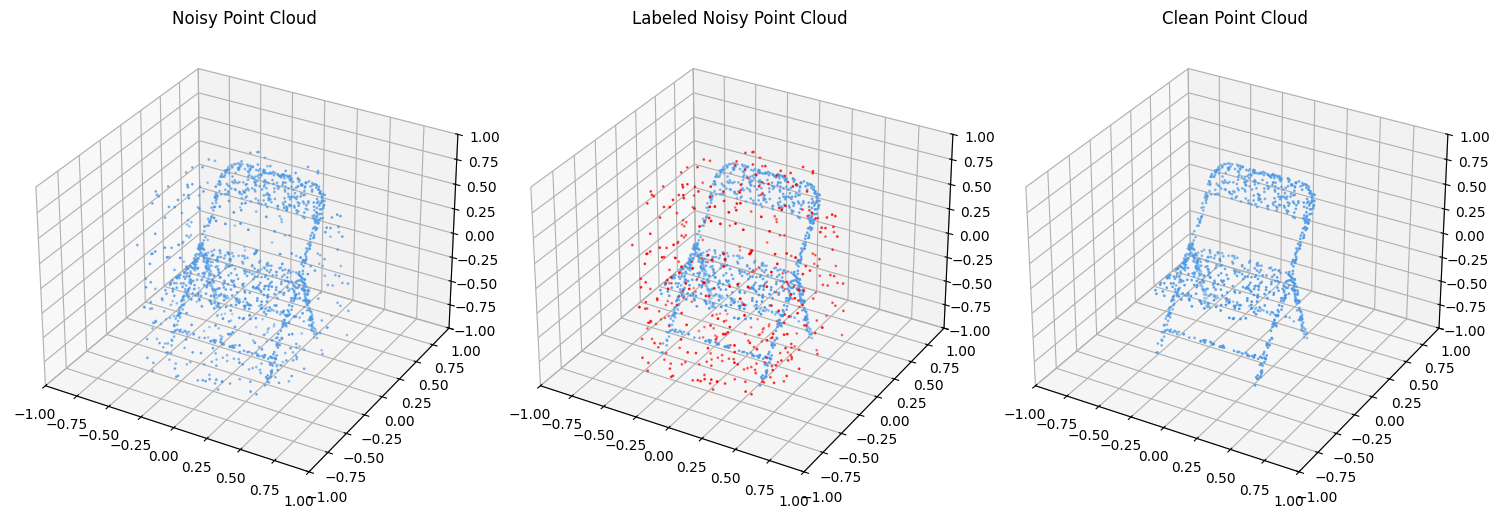

In [10]:
INTERACTIVE_VISUALIZATION = False

original_pcd = DatasetUtils.mesh_to_pointcloud("dataset/ModelNet10/chair/train/chair_0001.off")
noisy_pcd = DatasetUtils.add_valid_noise_to_pcd(original_pcd, 400, .2)
labels = DatasetUtils.generate_labels(original_pcd, 400)
noisy_pcd, labels = DatasetUtils.shuffle_tensors(noisy_pcd, labels)


DatasetUtils.plot_example(noisy_pcd, labels)
if INTERACTIVE_VISUALIZATION:
    DatasetUtils.visualize_noisy_pointcloud(noisy_pcd, labels)



### Synthetic Dataset Creation

We can now use our helper functions to go through each mesh file, extract a point cloud, corrupt the point cloud by adding noise, and label each point as either clean or noisy. This will leave us with a proper dataset for the task at hand

In [11]:
from torch.utils.data import Dataset
from tqdm import tqdm

class PointCloudDataset(Dataset):
    def __init__(self, root_dir: str):
        self.root_dir = root_dir
        self.pointcloud_files = []
        self.data = []
        self.length = 0
        self._initialize_dataset()

    def _initialize_dataset(self):
        """sample point clouds, obfuscate point cloud with noise, and generate labels for each sample"""
        for folder in os.listdir(self.root_dir):

            if folder == ".DS_Store": continue

            subfolder = os.path.join(self.root_dir, folder)
            train_folder = os.path.join(subfolder, "train")
            test_folder = os.path.join(subfolder, "test")

            for file in os.listdir(train_folder):
                file_path = os.path.join(train_folder, file)
                if not file_path.endswith(".off"): continue
                self.pointcloud_files.append(os.path.normpath(file_path))

            for file in os.listdir(test_folder):
                file_path = os.path.join(test_folder, file)
                if not file_path.endswith(".off"): continue
                self.pointcloud_files.append(os.path.normpath(file_path))


        self.length = len(self.pointcloud_files)

        for file in tqdm(self.pointcloud_files, desc="Generating point cloud dataset"):
            pcd = DatasetUtils.mesh_to_pointcloud(file, 2048)
            noisy_pcd = DatasetUtils.add_valid_noise_to_pcd(pcd, 500, .2)
            labels = DatasetUtils.generate_labels(pcd, 500)
            #noisy_pcd, labels = PointCloudUtils.shuffle_tensors(noisy_pcd, labels)
            self.data.append({"input": noisy_pcd, "output": labels})

        self.pointcloud_files.clear()

    def __len__(self) -> int:
        return self.length

    def __getitem__(self, index: int) -> str:
        return self.data[index]



Instantiate the PointCloudDataset and save it to file. If the dataset file already exists, load it from file to save time

In [12]:
import pickle

if os.path.exists("dataset/dataset.pickle"):
    print("Loading existing dataset")
    with open('dataset/dataset.pickle', 'rb') as handle:
        dataset = pickle.load(handle)
else:
    dataset = PointCloudDataset("dataset/ModelNet10")
    with open('dataset/dataset.pickle', 'wb') as handle:
        pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

Loading existing dataset


Let's visualize a few examples from the dataset

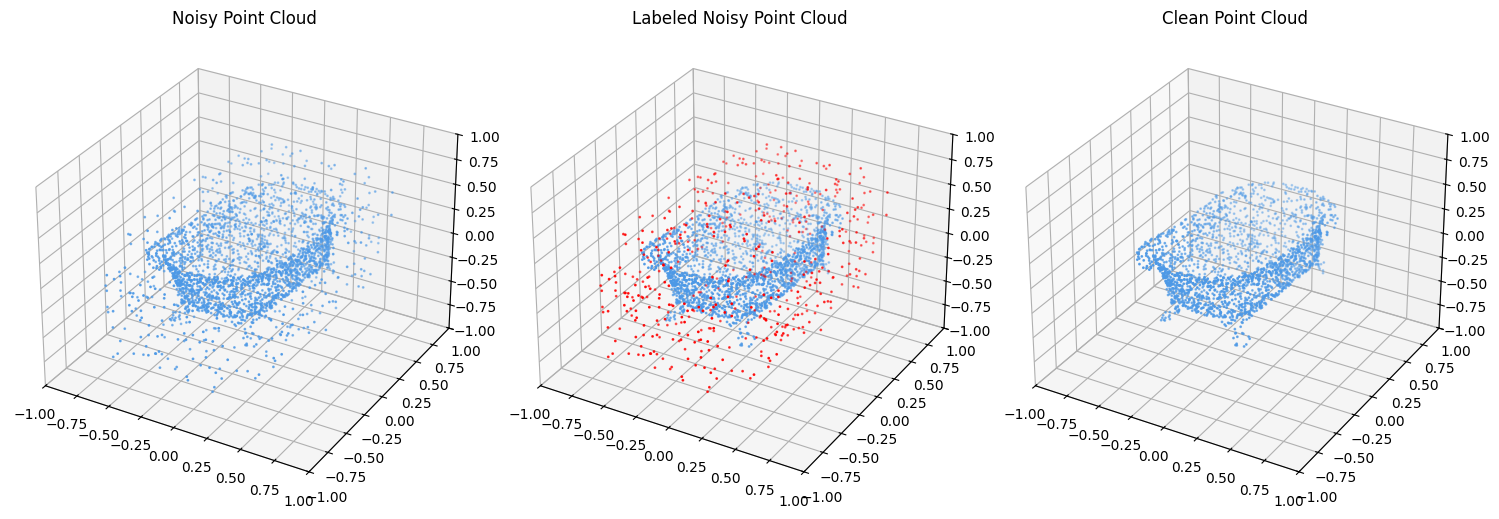

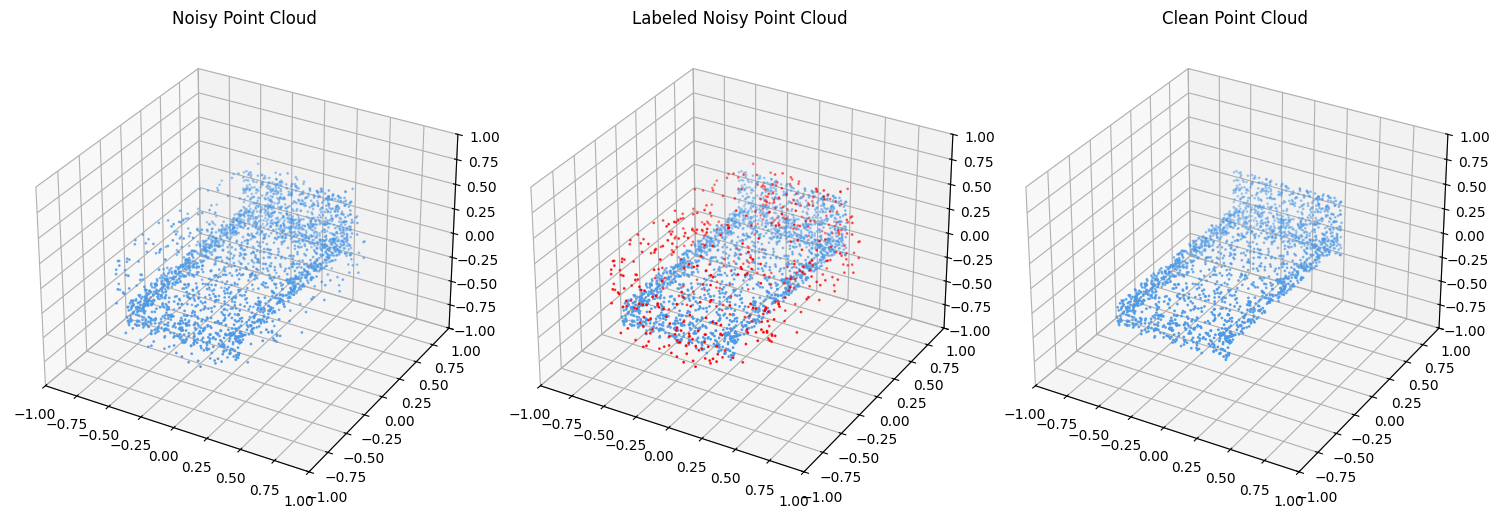

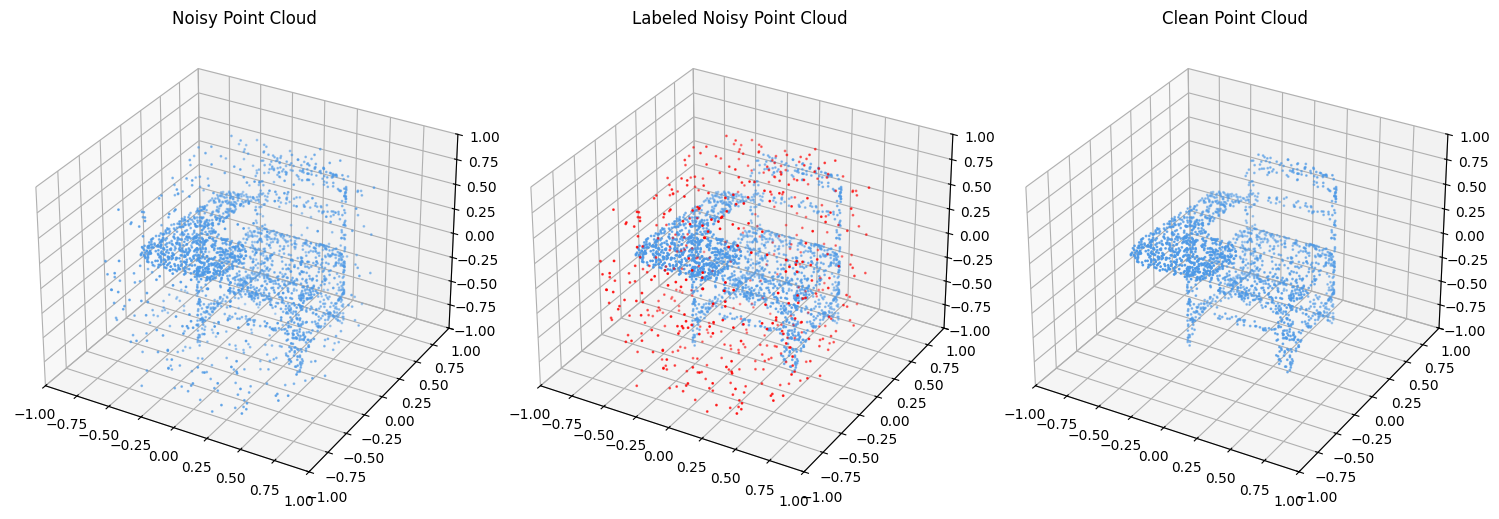

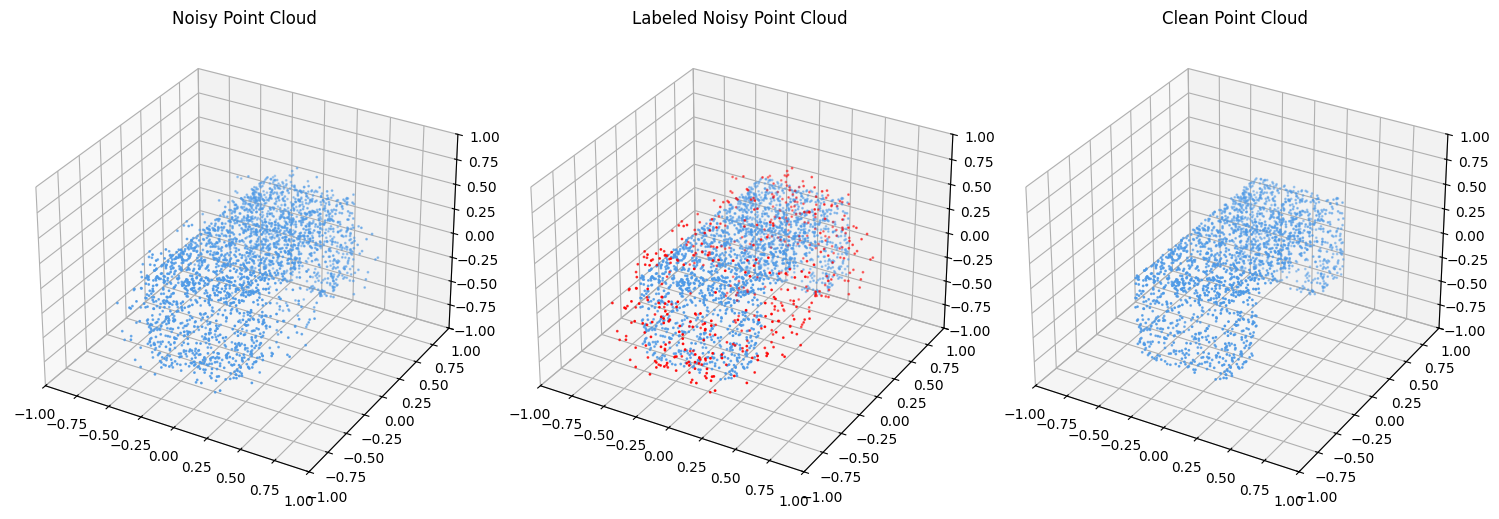

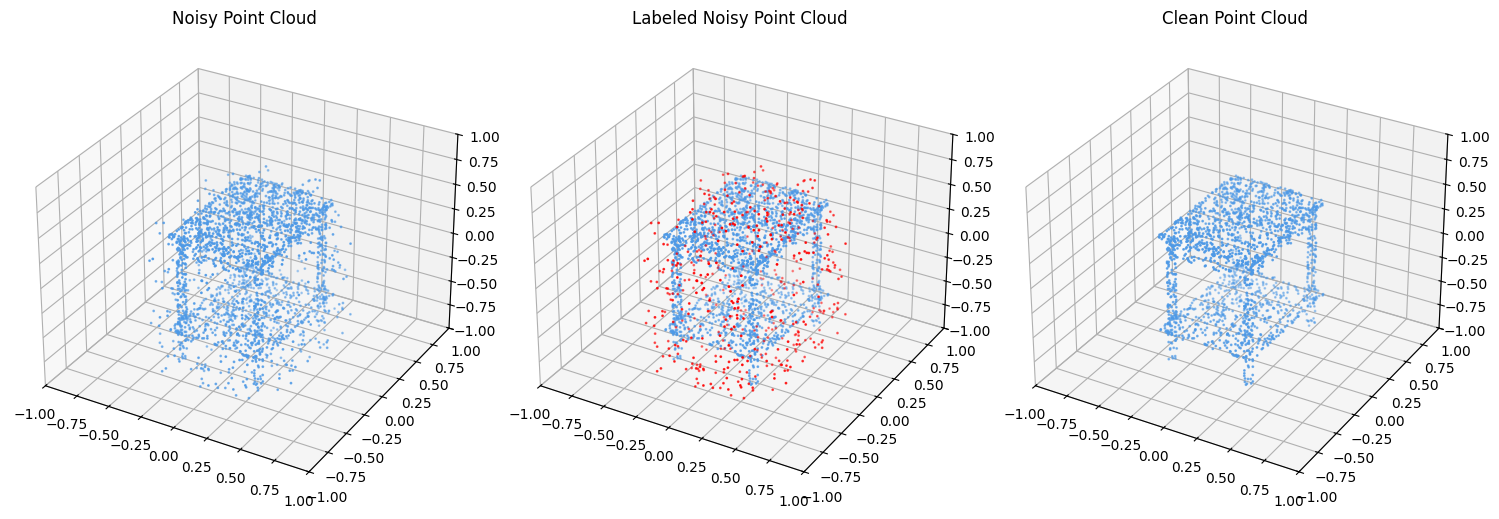

In [13]:
example_indexes = [4, 305, 800, 1805, 3000]

for idx in example_indexes:
    DatasetUtils.plot_example(dataset[idx]["input"], dataset[idx]["output"])
    if INTERACTIVE_VISUALIZATION:
        DatasetUtils.visualize_noisy_pointcloud(dataset[idx]["input"], dataset[idx]["output"])

In [14]:
import matplotlib.pyplot as plt
import torch

def predict_on_noisy_pcd(model, noisy_pcd: torch.Tensor, label: torch.Tensor):
    """Run the model on a noisy point cloud to get predictions"""
    

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.eval()
    noisy_pcd = noisy_pcd.to(device)
    
    noisy_pcd = noisy_pcd.unsqueeze(0)  # Shape: (1, num_points, 3)

    with torch.no_grad():
        predictions = model(noisy_pcd)

    predicted_labels = (predictions > 0.5).float()

    return predicted_labels.squeeze(0), label


def plot_predictions(noisy_pcd: torch.Tensor, predicted_labels: torch.Tensor, true_labels: torch.Tensor):
    """Plot the input noisy point cloud, predicted clean point cloud, and predicted labels"""
    
    # Move tensors to CPU and convert to numpy for visualization
    noisy_pcd_np = noisy_pcd.cpu().numpy()
    predicted_labels_np = predicted_labels.cpu().numpy()
    true_labels_np = true_labels.cpu().numpy()

    # Create a figure with 3 subplots
    fig = plt.figure(figsize=(18, 6))

    # Plot the noisy point cloud
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax1.scatter(noisy_pcd_np[:, 0], noisy_pcd_np[:, 1], noisy_pcd_np[:, 2], c='skyblue', s=1)
    ax1.set_title('Noisy Point Cloud')
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([-1, 1])
    ax1.set_zlim([-1, 1])

    # Plot true labels (clean vs noise)
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    scatter_true = ax2.scatter(noisy_pcd_np[:, 0], noisy_pcd_np[:, 1], noisy_pcd_np[:, 2], 
                                c=true_labels_np, cmap='bwr', s=1, alpha=0.7, vmin=0, vmax=1)
    ax2.set_title('Ground Truth Labels')
    ax2.set_xlim([-1, 1])
    ax2.set_ylim([-1, 1])
    ax2.set_zlim([-1, 1])

    # Plot predicted labels
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    scatter_pred = ax3.scatter(noisy_pcd_np[:, 0], noisy_pcd_np[:, 1], noisy_pcd_np[:, 2], 
                                c=predicted_labels_np, cmap='bwr', s=1, alpha=0.7, vmin=0, vmax=1)
    ax3.set_title('Predicted Labels')
    ax3.set_xlim([-1, 1])
    ax3.set_ylim([-1, 1])
    ax3.set_zlim([-1, 1])

    plt.tight_layout()
    plt.show()

    
def output_predicted_pcd(noisy_pcd: torch.Tensor, predictions: torch.Tensor):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    noisy_pcd = noisy_pcd.to(device)
    predictions = predictions.to(device)

    if predictions.dim() != 1 or predictions.size(0) != noisy_pcd.size(0):
        raise ValueError("Predictions must have shape (num_points,) matching the number of points in noisy_pcd")

    clean_mask = predictions > 0.5

    predicted_pcd = noisy_pcd[clean_mask]

    return predicted_pcd


## Train/Test Split

Now that we have our dataset, let's go ahead and split it into training and testing splits. We will choose a split of about 80% training examples and 20% testing examples

In [15]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_size = 4000
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


## Models

Now we can create the architecture for our models. We will start with a very simple model and continue on to a model that implements point net

#### Basic Model
Let's start with a basic convolutional model. We will implement the model architecture, its training loop, as well as a function to make predictions using the trained model. We will perform pointwise convolution as is done in the PointNet paper. This will allow us to change the dimensions of our input while keeping the correct spatial information 

#### MLP Models

The input to our MLP model will take the (x, y, z) points and stack them with their nearest neighbors. This will allows the model to get an idea as to the context that the points exist in. The nearest neighbors are calculated witha Scipy distance matrix which uses Minkowski p-norm

In [16]:
from scipy.spatial import distance_matrix

def stack_neighbors(input, num_neighbors):
    num_examples = len(input)
    num_samples = len(train_dataset[0]["input"])

    output = torch.zeros(num_examples, num_samples, 3 * (num_neighbors + 1))
    
    for i in range(num_examples):
        print(i)

        samples = train_dataset[i]["input"]
        matrix = distance_matrix(samples, samples)

        top_n_neighbors = np.argsort(matrix, axis=1)[:, :num_neighbors + 1]

        for j in range(num_samples):
            for k, neighbor in enumerate(top_n_neighbors[j]):
                start = 3 * k
                end = 3 * (k+1)

                output[i][j][start:end] = torch.tensor(samples[neighbor])

    return output


In [17]:
import torch
import torch.nn as nn

class PointNetDenoiserMLP(nn.Module):
    def __init__(self):
        super(PointNetDenoiserMLP, self).__init__()

        self.linear = nn.Linear(12, 1)
        self.relu = nn.ReLU()

    def forward(self, input):
        out = input
        out = self.linear(out)
        #out = self.relu(out)
        
        return out
    
class PointNetDenoiserMLPNonStacked(nn.Module):
    def __init__(self):
        super(PointNetDenoiserMLPNonStacked, self).__init__()

        self.linear = nn.Linear(3, 1)
        self.relu = nn.ReLU()

    def forward(self, input):
        out = input
        out = self.linear(out)
        #out = self.relu(out)
        
        return out
    

class PointWiseFeedForward(nn.Module):
    def __init__(self, e_dim):
        super(PointWiseFeedForward, self).__init__()

        self.linear1 = nn.Linear(3, e_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(e_dim, 3)

        self.linear3 = nn.Linear(3,1)
        self.softmax = nn.Softmax()

    def forward(self, input):
        out = input
        out = self.linear1(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.linear3(out)
        out = self.softmax(out)

        return out.squeeze(-1)



class PointNetDenoiserMLPWithPFF(nn.Module):
    def __init__(self, num_neighbors):
        super(PointNetDenoiserMLPWithPFF, self).__init__()

        self.num_neighbors = num_neighbors
        self.pff = PointWiseFeedForward(12)
        self.linear = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, input):
        out = input

        # Initial Prediction
        examples, samples, x = out.shape
        initial_pred = out.view(examples, samples, self.num_neighbors+1, 3)
        initial_pred = self.pff(initial_pred)

        # Combine data with initial preds
        out = torch.cat((out, initial_pred), dim=-1)

        out = self.linear(out)
        #out = self.relu(out)
        
        return out

In [56]:
def training_loop(epochs: int, model: nn.Module, train_data: torch.Tensor, train_labels: torch.Tensor):
    '''
    This functions takes the number of epochs and a model and then trains the model.
    Params:
        epochs: number of epochs the model will be trained
        model: the model that needs to be optimized for time series prediction
    '''
    loss_over_time = []

    #Construct the loss function
    criterion = torch.nn.BCEWithLogitsLoss()
    # Construct the optimizer (Stochastic Gradient Descent in this case)
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)  # lr is learning rate

    # Gradient Descent
    for epoch in range(epochs):
        # Forward pass: Compute predicted y by passing all training features at once to the model        
        Y_pred = model(train_data).squeeze(2)

        # Compute and print loss
        loss = criterion(Y_pred, train_labels)
        
        if epoch % 10 == 0: print(f'epoch: {epoch}, loss: {loss.item()}')

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()

        # Perform a backward pass (backpropagation)
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Track the loss
        loss_over_time.append(loss.item())
    
    return loss_over_time

In [57]:
import pickle

# Create the stacked train dataset or load the pickle file if it has already been calculated
if os.path.exists("dataset/stacked_dataset_train.pickle"):
    print("Loading existing dataset")
    with open('dataset/stacked_dataset_train.pickle', 'rb') as handle:
        stacked_train = pickle.load(handle)
else:
    stacked_train = stack_neighbors(train_dataset, 3)
    with open('dataset/stacked_dataset_train.pickle', 'wb') as handle:
        pickle.dump(stacked_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

Loading existing dataset


In [58]:
# Create the stacked test dataset or load the pickle file if it has already been calculated
if os.path.exists("dataset/stacked_dataset_test.pickle"):
    print("Loading existing dataset")
    with open('dataset/stacked_dataset_test.pickle', 'rb') as handle:
        stacked_test = pickle.load(handle)
else:
    stacked_test = stack_neighbors(test_dataset, 3)
    with open('dataset/stacked_dataset_test.pickle', 'wb') as handle:
        pickle.dump(stacked_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

Loading existing dataset


In [59]:
nonstacked_train = [train_dataset[i]['input'] for i in range(len(train_dataset))]
nonstacked_train = torch.stack(nonstacked_train)

nonstacked_test = [test_dataset[i]['input'] for i in range(len(test_dataset))]
nonstacked_test = torch.stack(nonstacked_test)

train_labels = [train_dataset[i]['output'] for i in range(len(train_dataset))]
train_labels = torch.stack(train_labels)

test_labels = [test_dataset[i]['output'] for i in range(len(test_dataset))]
test_labels = torch.stack(test_labels)

In [60]:
mlp_model = PointNetDenoiserMLP()

loss_over_time = training_loop(4000, mlp_model, stacked_train, train_labels)

epoch: 0, loss: 0.7148691415786743
epoch: 10, loss: 0.7049956917762756
epoch: 20, loss: 0.6955912113189697
epoch: 30, loss: 0.6866341233253479
epoch: 40, loss: 0.6781031489372253
epoch: 50, loss: 0.669978141784668
epoch: 60, loss: 0.6622399687767029
epoch: 70, loss: 0.6548696756362915
epoch: 80, loss: 0.6478495597839355
epoch: 90, loss: 0.6411626935005188
epoch: 100, loss: 0.6347926259040833
epoch: 110, loss: 0.6287238001823425
epoch: 120, loss: 0.6229414343833923
epoch: 130, loss: 0.6174313426017761
epoch: 140, loss: 0.6121799349784851
epoch: 150, loss: 0.6071745753288269
epoch: 160, loss: 0.602402925491333
epoch: 170, loss: 0.5978533029556274
epoch: 180, loss: 0.5935148000717163
epoch: 190, loss: 0.5893769860267639
epoch: 200, loss: 0.5854296684265137
epoch: 210, loss: 0.5816635489463806
epoch: 220, loss: 0.5780697464942932
epoch: 230, loss: 0.5746394991874695
epoch: 240, loss: 0.5713649392127991
epoch: 250, loss: 0.5682383179664612
epoch: 260, loss: 0.5652523636817932
epoch: 270, lo

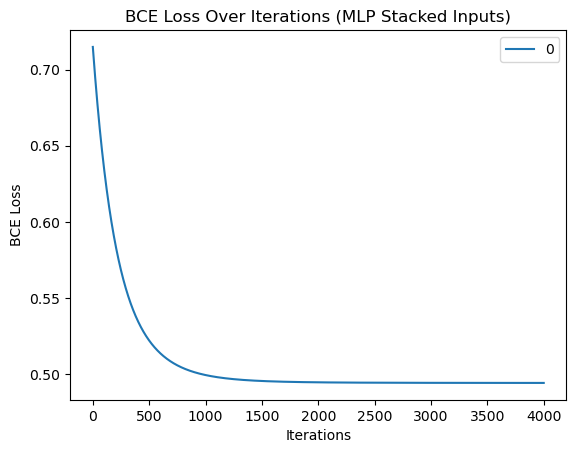

In [61]:
loss_plot = pd.DataFrame(loss_over_time)
loss_plot.plot()
plt.xlabel('Iterations')
plt.ylabel('BCE Loss')
plt.title('BCE Loss Over Iterations (MLP Stacked Inputs)')
plt.show()

In [62]:
criterion = torch.nn.BCEWithLogitsLoss()

test_preds = mlp_model(stacked_test).squeeze(2)
predicted = (torch.sigmoid(test_preds) > 0.5).float()
total_correct = (predicted == test_labels).sum().item()
total_incorrect = (predicted != test_labels).sum().item()
total = test_preds.shape[0] * test_preds.shape[1]

accuracy = round((total_correct / total)*100,2)
misclassification_rate = round((total_incorrect / total)*100,2)

print("BCE Loss for Test Data: ", criterion(test_preds, test_labels).item())
print("Accuracy for Test Data: ", accuracy, "%")
print("Misclassification Rate for Test Data: ", misclassification_rate, "%")

BCE Loss for Test Data:  0.49440738558769226
Accuracy for Test Data:  80.38 %
Misclassification Rate for Test Data:  19.62 %


In [66]:
test_preds[1][1:20]

tensor([1.4360, 1.4482, 1.3398, 1.3453, 1.4033, 1.4273, 1.3668, 1.4073, 1.2780,
        1.3869, 1.2919, 1.3338, 1.3005, 1.3248, 1.2983, 1.4674, 1.4351, 1.3893,
        1.3227], grad_fn=<SliceBackward0>)

In [ ]:
nonstacked_mlp_model = PointNetDenoiserMLPNonStacked()

loss_over_time = training_loop(4000, nonstacked_mlp_model, nonstacked_train, train_labels)

epoch: 0, loss: 0.6423130631446838
epoch: 10, loss: 0.6358292102813721
epoch: 20, loss: 0.6296553611755371
epoch: 30, loss: 0.6237756609916687
epoch: 40, loss: 0.6181755661964417
epoch: 50, loss: 0.6128407716751099
epoch: 60, loss: 0.607758104801178
epoch: 70, loss: 0.6029148101806641
epoch: 80, loss: 0.5982986688613892
epoch: 90, loss: 0.5938984751701355
epoch: 100, loss: 0.5897031426429749
epoch: 110, loss: 0.5857025384902954
epoch: 120, loss: 0.581886887550354
epoch: 130, loss: 0.5782468914985657
epoch: 140, loss: 0.5747738480567932
epoch: 150, loss: 0.5714592933654785
epoch: 160, loss: 0.5682954788208008
epoch: 170, loss: 0.5652748346328735
epoch: 180, loss: 0.5623905062675476
epoch: 190, loss: 0.5596355199813843
epoch: 200, loss: 0.5570037364959717
epoch: 210, loss: 0.5544889569282532
epoch: 220, loss: 0.5520855784416199
epoch: 230, loss: 0.549788236618042
epoch: 240, loss: 0.5475917458534241
epoch: 250, loss: 0.5454912781715393
epoch: 260, loss: 0.5434821844100952
epoch: 270, los

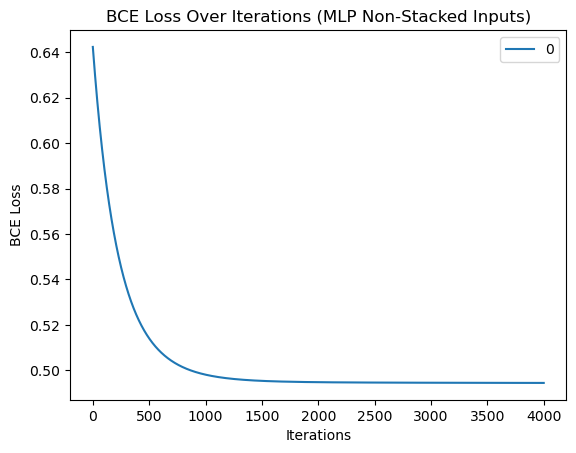

In [74]:
loss_plot = pd.DataFrame(loss_over_time)
loss_plot.plot()
plt.xlabel('Iterations')
plt.ylabel('BCE Loss')
plt.title('BCE Loss Over Iterations (MLP Non-Stacked Inputs)')
plt.show()

In [75]:
test_preds = nonstacked_mlp_model(nonstacked_test).squeeze(2)
predicted = (torch.sigmoid(test_preds) > 0.5).float()
total_correct = (predicted == test_labels).sum().item()
total = test_preds.shape[0] * test_preds.shape[1]

print("BCE Loss for Test Data: ", criterion(test_preds, test_labels).item())
print("Accuracy for Test Data: ", round((total_correct / total)*100,2), "%")

BCE Loss for Test Data:  0.494422048330307
Accuracy for Test Data:  80.38 %


In [115]:
improved_mlp = PointNetDenoiserMLPWithPFF(3)

# Maybe Increase with GPU
loss_over_time = training_loop(500, improved_mlp, stacked_train, train_labels)


epoch: 0, loss: 0.7115308046340942
epoch: 10, loss: 0.7016854286193848
epoch: 20, loss: 0.6923149228096008
epoch: 30, loss: 0.6833963990211487
epoch: 40, loss: 0.6749083399772644
epoch: 50, loss: 0.6668297052383423
epoch: 60, loss: 0.6591405272483826
epoch: 70, loss: 0.6518217921257019
epoch: 80, loss: 0.6448549032211304
epoch: 90, loss: 0.6382225751876831
epoch: 100, loss: 0.6319079995155334
epoch: 110, loss: 0.6258953213691711
epoch: 120, loss: 0.620169460773468
epoch: 130, loss: 0.6147159337997437
epoch: 140, loss: 0.6095209717750549
epoch: 150, loss: 0.6045715808868408
epoch: 160, loss: 0.5998553037643433
epoch: 170, loss: 0.5953606367111206
epoch: 180, loss: 0.591076135635376
epoch: 190, loss: 0.5869913101196289
epoch: 200, loss: 0.5830962657928467
epoch: 210, loss: 0.5793812274932861
epoch: 220, loss: 0.5758373141288757
epoch: 230, loss: 0.5724560022354126
epoch: 240, loss: 0.5692291259765625
epoch: 250, loss: 0.5661490559577942
epoch: 260, loss: 0.5632084608078003
epoch: 270, lo

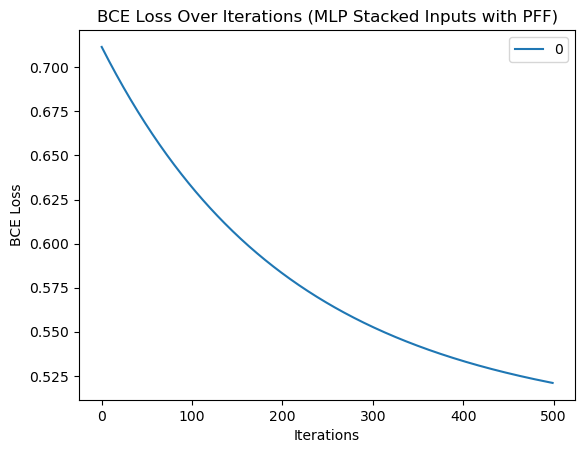

In [116]:
loss_plot = pd.DataFrame(loss_over_time)
loss_plot.plot()
plt.xlabel('Iterations')
plt.ylabel('BCE Loss')
plt.title('BCE Loss Over Iterations (MLP Stacked Inputs with PFF)')
plt.show()

In [118]:
test_preds = improved_mlp(stacked_test).squeeze(2)
predicted = (torch.sigmoid(test_preds) > 0.5).float()
total_correct = (predicted == test_labels).sum().item()
total = test_preds.shape[0] * test_preds.shape[1]

print("BCE Loss for Test Data: ", criterion(test_preds, test_labels).item())
print("Accuracy for Test Data: ", round((total_correct / total)*100,2), "%")

BCE Loss for Test Data:  0.521033525466919
Accuracy for Test Data:  80.38 %


#### Convolution Model

In [18]:
class PointNetDenoiser(nn.Module):
    def __init__(self):
        super(PointNetDenoiser, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.conv4 = nn.Conv1d(1024, 512, 1)
        self.conv5 = nn.Conv1d(512, 256, 1)
        self.conv6 = nn.Conv1d(256, 1, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, input):
        # input shape: batch_size (16) x num_points (4596) x 3
        input = input.permute(0, 2, 1)
        input = self.relu(self.conv1(input))
        input = self.relu(self.conv2(input))
        input = self.relu(self.conv3(input))
        input = self.relu(self.conv4(input))

        input = self.dropout(self.relu(self.conv5(input)))
        input = self.conv6(input)
        input = input.squeeze(1)
        
        # output shape: batch_size (16) x num_points
        return input

#### Basic model training loop

In [19]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

def train_basic_model(model: PointNetDenoiser, epochs: int):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_points = 0
        
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs} - Average Loss: 0.0000")
        for i, entry in pbar:
            points = entry["input"].to(device).float()
            labels = entry["output"].to(device).float()

            optimizer.zero_grad()
            outputs = model(points)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            avg_loss = total_loss / (i + 1)
            pbar.set_description(f"Epoch {epoch + 1}/{epochs} - Average Loss: {avg_loss:.4f}")

        # Evaluate on test set
        model.eval()
        total_correct = 0
        total_points = 0
        with torch.no_grad():
            for entry in tqdm(test_loader, desc="Evaluating", unit="batch"):
                points = entry["input"].to(device).float()
                labels = entry["output"].to(device).float()

                outputs = model(points)
                predicted = (torch.sigmoid(outputs) > 0.5).float()

                total_points += labels.numel()  # Total number of points
                total_correct += (predicted == labels).sum().item()

        accuracy = 100. * total_correct / total_points
        print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {total_loss / len(train_loader):.4f}, Accuracy: {accuracy:.2f} %')


#### Run Inference Using Basic Model

In [20]:
def base_model_predict(model: PointNetDenoiser, noisy_pcd_input: torch.Tensor) -> torch.Tensor:
    """make predictions on the given noisy point cloud"""

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.eval()
    noisy_pcd_input = noisy_pcd_input.to(device)
    noisy_pcd_input = noisy_pcd_input.unsqueeze(0)

    with torch.no_grad():
        predictions = model(noisy_pcd_input)

    predicted_labels = (predictions > 0.5).float()

    return predicted_labels.squeeze(0)

In [21]:
model = PointNetDenoiser()
train_basic_model(model, 3)

Evaluating: 100%|██████████| 57/57 [00:00<00:00, 94.87batch/s]


Epoch 1/3, Average Loss: 0.3600, Accuracy: 86.27 %


Evaluating: 100%|██████████| 57/57 [00:00<00:00, 95.64batch/s]


Epoch 2/3, Average Loss: 0.3304, Accuracy: 86.56 %


Evaluating: 100%|██████████| 57/57 [00:00<00:00, 95.22batch/s]

Epoch 3/3, Average Loss: 0.3256, Accuracy: 86.70 %


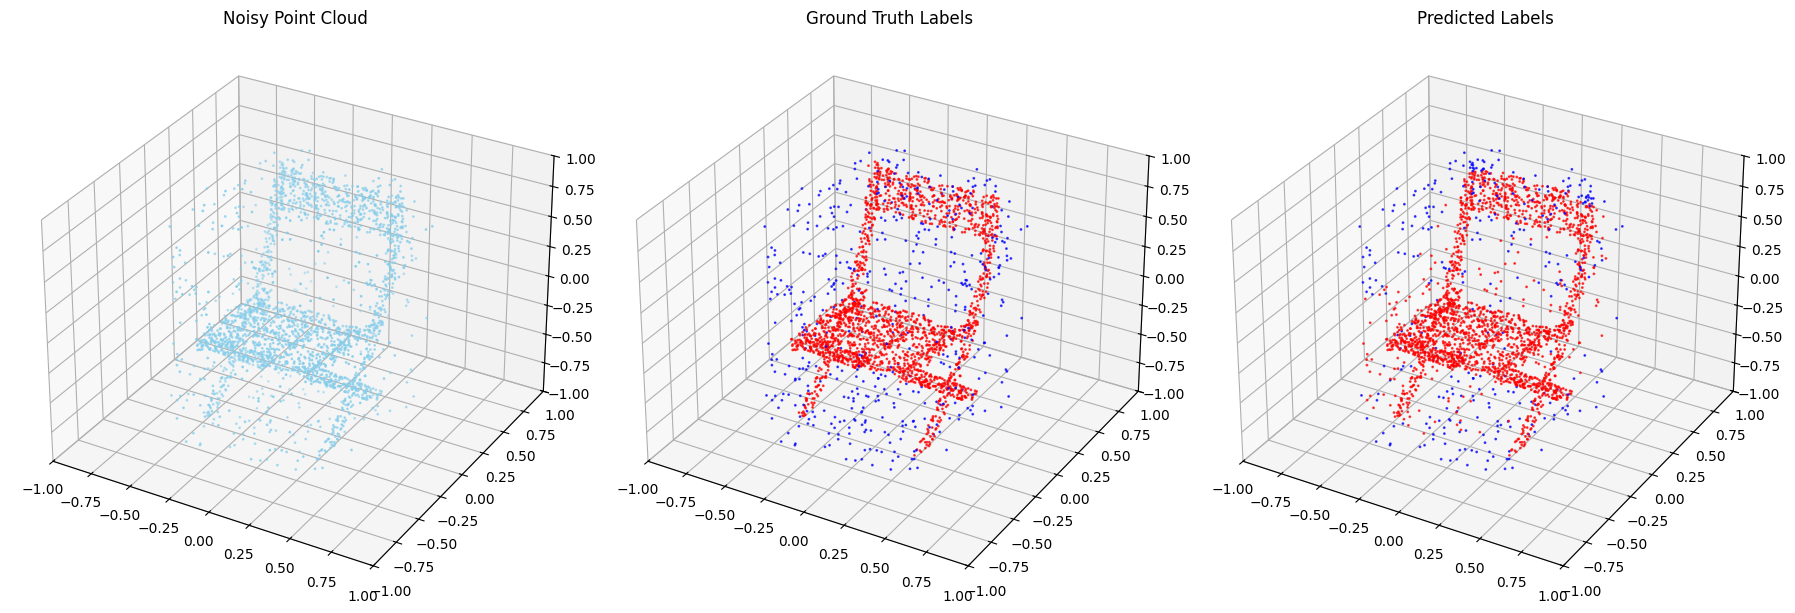

In [23]:
noisy_pcd_input = dataset[1600]["input"]
true_output = dataset[1600]["output"] 
predictions = base_model_predict(model, noisy_pcd_input)
plot_predictions(noisy_pcd_input, predictions, true_output)

In [24]:
predicted_pcd = output_predicted_pcd(dataset[1600]["input"], predictions)
DatasetUtils.visualize_pointcloud(predicted_pcd)

===============================================================================

### PointNet Model

Now, lets go ahead and implement a model that utilizes a variation of the PointNet. PointNet uses a layer called a tnet, which effectively learns a transformation matrix that can be applied to the input point cloud. This transformation matrix helps to make point cloud points invariant to permutations, such as rigid transformations. This will allow the model to learn better on point clouds

In [26]:
class TNet(nn.Module):
    def __init__(self, k=3):
        super(TNet, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(k, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, k * k)
        )
        self.k = k

    def forward(self, x):
        B, N, k = x.size()
        x = x.transpose(1, 2) # (B, k, N) for shared MLP
        x = self.mlp(x.max(2)[0]) # Global feature aggregation, output (B, 1024)
        x = self.fc(x) # Output (B, k*k)
        identity = torch.eye(self.k, requires_grad=False).repeat(B, 1, 1).to(x.device)
        matrix = x.view(B, self.k, self.k) + identity
        return matrix
    


class DenoisePointNet(nn.Module):
    def __init__(self, input_dim=3):
        super(DenoisePointNet, self).__init__()
        
        # Input TNet with input_dim (3 for x, y, z)
        self.input_tnet = TNet(k=input_dim)
        
        # Feature TNet with 256 dimensions to match MLP1 output
        self.feature_tnet = TNet(k=256)
        
        # Shared MLP for point features
        self.mlp1 = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        # Global feature extraction
        self.global_mlp = nn.Sequential(
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )

        # Point-wise classification MLP
        self.classifier = nn.Sequential(
            nn.Linear(1280, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        B, N, F = x.size()

        trans_input = self.input_tnet(x)
        x = torch.bmm(x, trans_input)

        x = x.view(B * N, F)
        local_features = self.mlp1(x)
        local_features = local_features.view(B, N, 256)

        trans_feat = self.feature_tnet(local_features)
        local_features = torch.bmm(local_features, trans_feat)

        global_features = torch.max(local_features, dim=1, keepdim=False)[0] # (B, 256)
        global_features = self.global_mlp(global_features) # (B, 1024)

        global_features = global_features.unsqueeze(1).expand(-1, N, -1)
        combined_features = torch.cat([local_features, global_features], dim=2)
        combined_features = combined_features.view(B * N, -1)
        output = self.classifier(combined_features)

        return output.view(B, N)


#### PointNet Model Training Loop

In [28]:

def train_pointnet_model(model, dataloader, optimizer, criterion, num_epochs=10, device='cuda'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            points, labels = batch['input'].to(device), batch['output'].to(device)

            optimizer.zero_grad()
            outputs = model(points)

            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.numel()
        
        epoch_loss = running_loss / len(dataloader)
        epoch_accuracy = correct / total * 100
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


#### Run Inference Using PointNet Model

In [27]:
def pointnet_model_predict(model: DenoisePointNet, noisy_pcd_input: torch.Tensor) -> torch.Tensor:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    with torch.no_grad():
        output, matrix3x3, matrix64x64 = model(noisy_pcd_input.unsqueeze(0).transpose(1, 2).to(device))
        predictions = (torch.sigmoid(output) > 0.5).float()
    return predictions

In [30]:
pointnet_model = DenoisePointNet()
optimizer = optim.Adam(pointnet_model.parameters(), lr=0.001)
criterion = nn.BCELoss()

train_pointnet_model(pointnet_model, train_loader, optimizer, criterion, num_epochs=10)

Epoch 1/10: 100%|██████████| 250/250 [00:09<00:00, 26.53it/s]


Epoch 1, Loss: 0.2916, Accuracy: 87.72%


Epoch 2/10: 100%|██████████| 250/250 [00:08<00:00, 28.88it/s]


Epoch 2, Loss: 0.1963, Accuracy: 92.08%


Epoch 3/10: 100%|██████████| 250/250 [00:08<00:00, 28.71it/s]


Epoch 3, Loss: 0.1668, Accuracy: 93.34%


Epoch 4/10: 100%|██████████| 250/250 [00:08<00:00, 28.69it/s]


Epoch 4, Loss: 0.1585, Accuracy: 93.73%


Epoch 5/10: 100%|██████████| 250/250 [00:08<00:00, 28.85it/s]


Epoch 5, Loss: 0.1463, Accuracy: 94.29%


Epoch 6/10: 100%|██████████| 250/250 [00:08<00:00, 28.84it/s]


Epoch 6, Loss: 0.1373, Accuracy: 94.67%


Epoch 7/10: 100%|██████████| 250/250 [00:08<00:00, 28.81it/s]


Epoch 7, Loss: 0.1330, Accuracy: 94.84%


Epoch 8/10: 100%|██████████| 250/250 [00:08<00:00, 28.82it/s]


Epoch 8, Loss: 0.1274, Accuracy: 95.09%


Epoch 9/10: 100%|██████████| 250/250 [00:08<00:00, 28.82it/s]


Epoch 9, Loss: 0.1255, Accuracy: 95.15%


Epoch 10/10: 100%|██████████| 250/250 [00:08<00:00, 28.89it/s]

Epoch 10, Loss: 0.1207, Accuracy: 95.39%


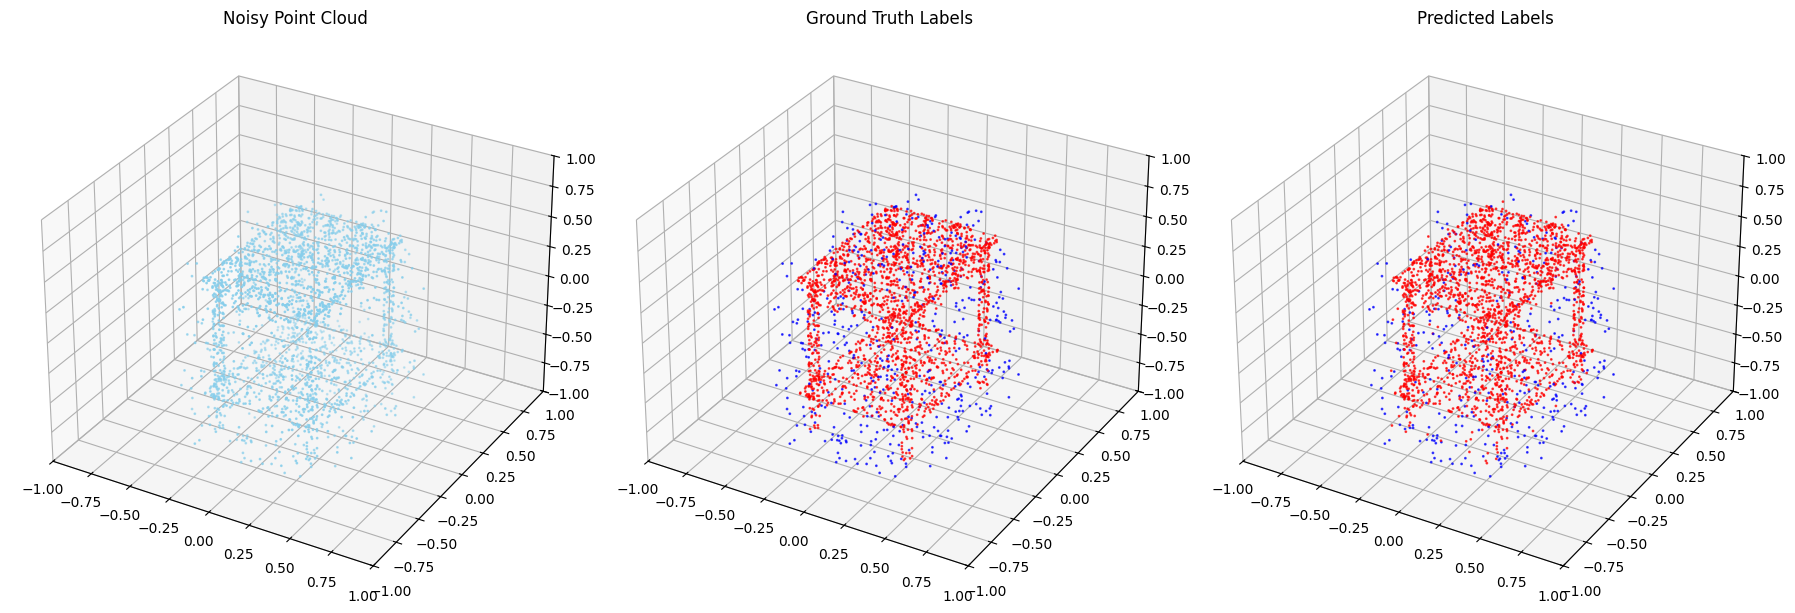

In [32]:
idx = 3000
noisy_pcd_input = dataset[idx]["input"]
true_output = dataset[idx]["output"]

pointnet_predictions = base_model_predict(pointnet_model, noisy_pcd_input)

plot_predictions(noisy_pcd_input, pointnet_predictions, true_output)

In [130]:
#import time

#output_path = f'models/denoise_net_{int(time.time())}.pth'
#torch.save(model.state_dict(), output_path)
#print(f"Model saved as '{output_path}'")

In [131]:
predicted_pcd = output_predicted_pcd(noisy_pcd_input, predictions.squeeze(0))
DatasetUtils.visualize_pointcloud(predicted_pcd)

In [132]:
import random
def interactive_point_with_neighbors(stacked_input: torch.Tensor):
    """display a pointcloud with a randomly chosen point and it's neighbors highlighted in an interactive window"""
    main_points = stacked_input[:, :3].numpy()

    random_point_idx = random.randint(0, len(main_points) - 1)
    neighbors = stacked_input[random_point_idx, 3:].view(3, 3).numpy()

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(main_points)
    colors = np.full((len(main_points), 3), [0.9, 0.9, 0.9])

    # Highlight the chosen point in red
    colors[random_point_idx] = [1, 0, 0]

    for neighbor in neighbors:
        # Find the index of the neighbor in the main points
        idx = np.where((main_points == neighbor).all(axis=1))[0]
        if idx.size > 0:
            colors[idx[0]] = [0, 1, 0]

    point_cloud.colors = o3d.utility.Vector3dVector(colors)

    o3d.visualization.draw_geometries([point_cloud], window_name="Point Cloud Visualization",
                                      width=800, height=600, point_show_normal=False)


interactive_point_with_neighbors(stacked_train[0])